In [1]:
import pandas as pd
import numpy as np
import faiss
import networkx as nx
import matplotlib.pyplot as plt

# Initial Code

In [2]:
# Load the CSV file
file_path = '/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/10_OC_romi_embeddings.csv'  
df = pd.read_csv(file_path)

# Extract TCR sequences and embeddings
tcr_sequences = df.iloc[:, 0].values
embeddings = df.iloc[:, 1:].values.astype('float32')

In [3]:
print(df)

          Sequences         0         1         2         3         4  \
0       CAVNTGNQFYF  0.308239 -0.294122  0.913678  0.181140  0.142057   
1      CAVNQAGTALIF  0.415509  0.290809  0.747347 -0.488818  0.169983   
2      CAVNTGGFKTIF  0.163495  0.080760  0.476694 -0.579615  0.884860   
3      CAVNTGFQKLVF -0.022703 -0.812257  0.003813 -0.729871  0.204372   
4      CAVNTNAGKSTF  0.825351  0.309570  0.711203 -0.059717  0.797822   
..              ...       ...       ...       ...       ...       ...   
441   CAASSTGGFKTIF  0.299344  0.045450  0.571454 -0.776035  0.952110   
442  CASSLEGNTGELFF  0.503732 -0.498401  0.627391  0.004685 -0.282559   
443    CASSLLNTEAFF  0.519638 -0.023229  0.459755 -0.059909 -0.353025   
444   CASSRDRQETQYF  0.352382 -0.315359  0.805187  0.452733 -0.506751   
445   CALTNFGNEKLTF  0.100257  0.462869  0.679575  0.664840  0.570774   

            5         6         7         8  ...       758       759  \
0   -0.520598  0.134298  0.613036 -1.186842  ... -0

In [4]:
# Normalize the embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
print(embeddings[:5])

[[ 0.02066291 -0.01971656  0.06124866 ... -0.00032533 -0.01986768
  -0.02831196]
 [ 0.02679525  0.0187536   0.04819477 ...  0.01685769  0.03143948
   0.05830424]
 [ 0.01085496  0.00536194  0.03164933 ... -0.0181109  -0.05642576
   0.0057394 ]
 [-0.00154362 -0.05522626  0.00025922 ...  0.00202742 -0.03296808
   0.07079446]
 [ 0.05196872  0.01949227  0.04478134 ... -0.05114776 -0.01631641
  -0.0275614 ]]


In [5]:
# # Create a FAISS index for inner product search on GPU

# res = faiss.StandardGpuResources()  # Initialize GPU resources
# index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
# gpu_index = faiss.index_cpu_to_gpu(res, 0, index)  # Transfer index to GPU
# gpu_index.add(embeddings)

In [6]:
## FAISS index on CPU

# Create a FAISS index for inner product search on CPU
index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
index.add(embeddings)

In [7]:
# Query the index to get similarity scores
similarity_matrix = np.dot(embeddings, embeddings.T)

In [8]:
# Perform the nearest neighbor search using FAISS on CPU
k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(embeddings, k)

# # for GPU:
# distances, indices = gpu_index.search(embeddings, k)

In [9]:
print("Distances:", distances[:5])  # Print the distances for the first 5 embeddings
print("Indices:", indices[:5])      # Print the indices for the first 5 embeddings


Distances: [[1.0000005  0.9551598  0.95262384 0.9465788  0.9380958 ]
 [1.         0.96681595 0.9613152  0.959839   0.95576036]
 [0.99999994 0.9589876  0.9580058  0.949825   0.9416541 ]
 [0.9999997  0.9590902  0.9560313  0.94388133 0.5724197 ]
 [1.0000001  0.963938   0.9615434  0.94803977 0.90991867]]
Indices: [[  0 107  43 323  83]
 [  1  42 183 215  68]
 [  2 175  17 123 267]
 [  3 184 270 167   2]
 [  4 124  63 377 357]]


In [10]:
# Create the adjacency matrix
num_embeddings = embeddings.shape[0]
adjacency_matrix = np.zeros((num_embeddings, num_embeddings))

for i in range(num_embeddings):
    for j in range(1, k):  # Skip the first neighbor (itself)
        adjacency_matrix[i, indices[i, j]] = distances[i, j]

In [11]:
print(adjacency_matrix[:1])  # Print the top-left 5x5 part of the adjacency matrix for inspection


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.95262384 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.93809581
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.      

In [12]:
# Create a graph using NetworkX
G = nx.Graph()

# Add nodes
for i, seq in enumerate(tcr_sequences):
    G.add_node(i, label=seq)

# Add edges based on the adjacency matrix
threshold = 0.8  # Adjust this threshold as needed
for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        if adjacency_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=adjacency_matrix[i, j])



In [13]:
# Function to create and visualize graph at a given threshold
def visualize_graph(threshold):
    G = nx.Graph()
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            if adjacency_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=adjacency_matrix[i, j])
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=20, with_labels=False)
    plt.title(f'Graph Visualization at Threshold {threshold}')
    plt.show()

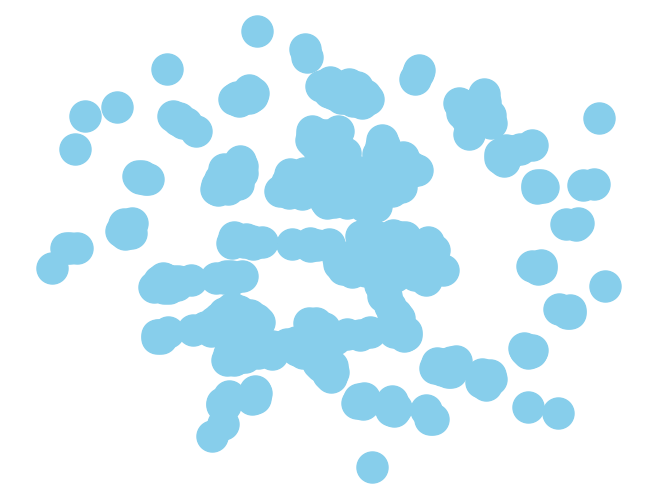

In [14]:
# Visualize the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=500, node_color="skyblue", font_size=10, font_weight="bold")
plt.show()


In [16]:
# def create
# # Load the CSV file
# file_path = '/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/10_OC_romi_embeddings.csv'  # Replace with your file path
# df = pd.read_csv(file_path)

# # Extract TCR sequences and embeddings
# tcr_sequences = df.iloc[:, 0].values
# embeddings = df.iloc[:, 1:].values.astype('float32')

Factors to Consider
1. Graph Sparsity and Density:
    - Sparsity: A sparse graph, where nodes have fewer edges, can help highlight strong relationships and reduce noise. This is particularly important if you want to focus on highly similar sequences.
    - Density: A denser graph might be more appropriate if you want to capture a broader range of relationships, including weaker similarities.
2. Natural Grouping:
    - Aim for a threshold that allows natural clusters or communities to emerge in the graph, similar to how editing distance 1 created natural groupings.
    You want to avoid a threshold that results in either an overly connected (complete) graph or a graph with many isolated nodes.
3. Average Node Degree:
    - Consider the average number of connections (degree) each node should have. You mentioned preferring a natural variation in graph degrees, so choose a threshold that provides a reasonable average degree while allowing for variability.
4. Application-Specific Requirements:
    - Think about the downstream analysis you plan to perform on the graph. For example, if you are looking for closely related sequences, a higher threshold might be better. If you want to capture broader relationships, a lower threshold might be more suitable.


# Exploring the Embedding

The histogram shows the distribution of the distances in your adjacency matrix.

Statistical Summary: Percentiles give a concise statistical summary of the distribution. They tell you how the distances are spread out and help in understanding the central tendency and dispersion.

Threshold Selection: By knowing the percentiles, you can make informed decisions about setting the threshold. For example, if you choose the 90th percentile as a threshold, you are considering the top 10% of the highest similarity scores (or lowest distances) for creating edges in your graph.

X-axis (Distance): This represents the distance (or similarity score) between pairs of embeddings. Since you're using cosine similarity, these values typically range from 0 to 1.

Y-axis (Frequency): This indicates how many pairs of embeddings fall into each distance range (bin). It shows the count of distance values within each bin interval.

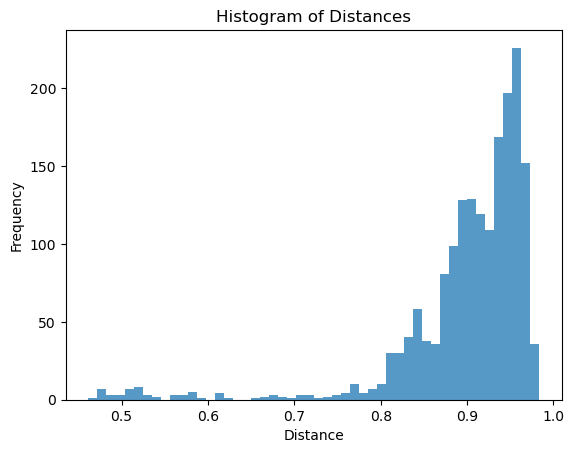

Percentiles of Distances: [0.88200074 0.92055023 0.95097452 0.96383733 0.96875203 0.97584031]


In [17]:

# Flatten the adjacency matrix and filter out zero distances
distances_flat = adjacency_matrix.flatten()
distances_flat = distances_flat[distances_flat > 0]

# Plot histogram of distances
plt.hist(distances_flat, bins=50, alpha=0.75)
plt.title('Histogram of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Calculate and print percentiles
percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
print("Percentiles of Distances:", percentiles)


Most distances are concentrated in the higher range (around 0.8 to 1), with very few distances below 0.7. This indicates that most of the similarities between embeddings are relatively high, suggesting that a higher threshold might be appropriate to capture meaningful connections.



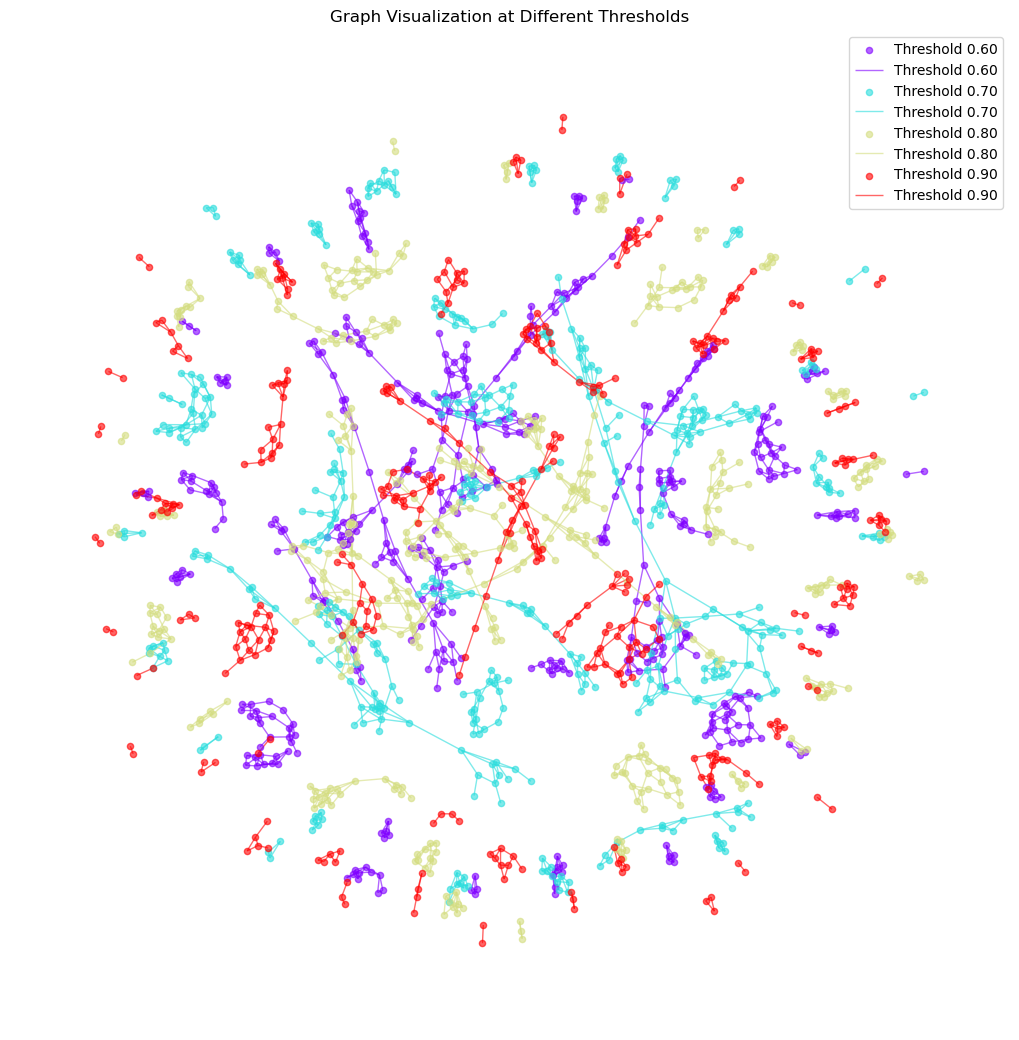

In [18]:
import matplotlib.cm as cm

# Function to create and visualize graphs at different thresholds in the same plot
def visualize_graphs(thresholds):
    colors = cm.rainbow(np.linspace(0, 1, len(thresholds)))  # Generate distinct colors

    plt.figure(figsize=(10, 10))

    for idx, threshold in enumerate(thresholds):
        G = nx.Graph()
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_size=20, node_color=[colors[idx]], edge_color=colors[idx], with_labels=False, alpha=0.6, label=f'Threshold {threshold:.2f}')
    
    plt.title('Graph Visualization at Different Thresholds')
    plt.legend()
    plt.show()

# Define thresholds to visualize
thresholds = [0.6, 0.7, 0.8, 0.9]
visualize_graphs(thresholds)

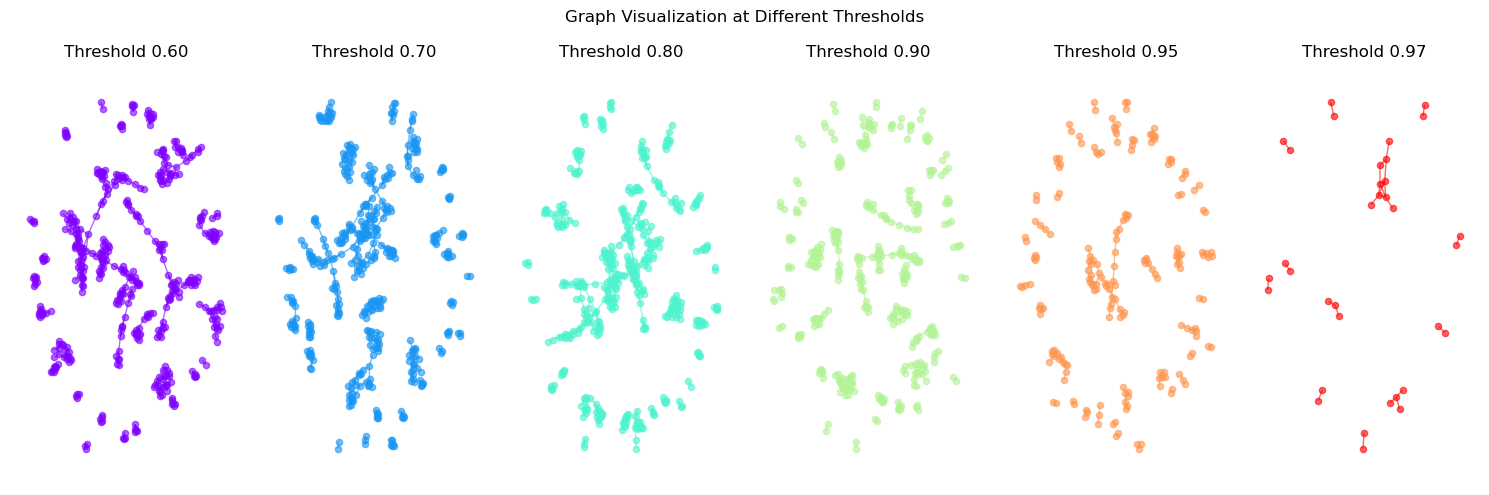

In [19]:
import matplotlib.cm as cm

# Function to create and visualize graphs at different thresholds in separate subplots
def visualize_graphs(thresholds):
    colors = cm.rainbow(np.linspace(0, 1, len(thresholds)))  # Generate distinct colors
    num_thresholds = len(thresholds)
    fig, axes = plt.subplots(1, num_thresholds, figsize=(15, 5))  # Create subplots

    for idx, (threshold, ax) in enumerate(zip(thresholds, axes)):
        G = nx.Graph()
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        pos = nx.spring_layout(G)
        nx.draw(G, pos, ax=ax, node_size=20, node_color=[colors[idx]], edge_color=colors[idx], with_labels=False, alpha=0.6)
        ax.set_title(f'Threshold {threshold:.2f}')
    
    plt.suptitle('Graph Visualization at Different Thresholds')
    plt.tight_layout()
    plt.show()

# Define thresholds to visualize
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95, 0.97]
visualize_graphs(thresholds)

In [20]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.components import number_connected_components

# Function to evaluate metrics at a given threshold
def evaluate_metrics(threshold):
    G = nx.Graph()
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            if adjacency_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=adjacency_matrix[i, j])
    clustering_coefficient = average_clustering(G)
    num_components = number_connected_components(G)
    avg_degree = np.mean([d for _, d in G.degree])
    return clustering_coefficient, num_components, avg_degree

# Evaluate metrics at different thresholds
thresholds = [0.6, 0.7, 0.8, 0.9]
metrics = [evaluate_metrics(t) for t in thresholds]

for t, (cc, nc, ad) in zip(thresholds, metrics):
    print(f'Threshold: {t}, Clustering Coefficient: {cc}, Number of Components: {nc}, Average Degree: {ad}')


Threshold: 0.6, Clustering Coefficient: 0.4753931847968546, Number of Components: 34, Average Degree: 3.481651376146789
Threshold: 0.7, Clustering Coefficient: 0.4810837438423645, Number of Components: 36, Average Degree: 3.471264367816092
Threshold: 0.8, Clustering Coefficient: 0.4809193885406354, Number of Components: 36, Average Degree: 3.4364896073903
Threshold: 0.9, Clustering Coefficient: 0.4204951298701298, Number of Components: 53, Average Degree: 2.9318181818181817


## Trying different threshold/Nearest neightboor valuess
1. sqrt N:
    - Pros: Provides a reasonable balance between sparsity and connectivity. Ensures that each node has a sufficient number of neighbors without becoming too dense, even for large graphs.
    - Cons: Can become large for very large graphs, potentially increasing computational complexity.

2. log(𝑁)
    - Pros: Keeps the number of neighbors relatively small, ensuring sparsity even for very large graphs. Reduces computational complexity.
    - Cons: Might not capture enough neighbors for smaller graphs, potentially missing important connections.

In [2]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.components import number_connected_components
import matplotlib.cm as cm

def evaluating_thresholds(file_path):
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

    # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        clustering_coefficient = average_clustering(G)
        num_components = number_connected_components(G)
        return clustering_coefficient, num_components, G

    # Define different k values and thresholds to explore
    N = embeddings.shape[0]
    k_values = [5, 10, 15, 20, int(np.sqrt(N)), int(np.log(N)) + 1]
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95] # Example thresholds between 0.5 and 0.9

    # Iterate over different k values and thresholds
    results = []
    graphs = {}  # Dictionary to store graphs
    for k in k_values:
        distances, indices = create_faiss_index(embeddings, k)
        adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
        for threshold in thresholds:
            cc, nc, G = evaluate_metrics(adjacency_matrix, threshold)
            results.append((k, threshold, cc, nc))
            graphs[(k, threshold)] = G  # Store the graph with (k, threshold) as key

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results, columns=['k', 'threshold', 'clustering_coefficient', 'num_components'])
    print(results_df)

    # Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot clustering coefficient
    for k in k_values:
        subset = results_df[results_df['k'] == k]
        axes[0].plot(subset['threshold'], subset['clustering_coefficient'], label=f'k={k}')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Clustering Coefficient')
    axes[0].legend()
    axes[0].set_title('Clustering Coefficient vs Threshold for Different k Values')

    # Plot number of components
    for k in k_values:
        subset = results_df[results_df['k'] == k]
        axes[1].plot(subset['threshold'], subset['num_components'], label=f'k={k}')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Number of Components')
    axes[1].legend()
    axes[1].set_title('Number of Components vs Threshold for Different k Values')

    plt.tight_layout()
    plt.show()

    # Flatten the adjacency matrix and filter out zero distances
    distances_flat = adjacency_matrix.flatten()
    distances_flat = distances_flat[distances_flat > 0]

    # Plot histogram of distances
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.hist(distances_flat, bins=50, alpha=0.75)
    ax2.set_title('Histogram of Distances')
    ax2.set_xlabel('Cosine Similarity Distance')
    ax2.set_ylabel('Frequency (Pairs Count)')
    plt.show()

    # Calculate and print percentiles
    percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
    print("Percentiles of Distances:", percentiles)


In [54]:
def create_graphs_from_embeddings(file_path, threshold):
    # Load the CSV file
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

   # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold, node_names):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i, j])
        return G

    # Create FAISS index and search for nearest neighbors
    k = int(np.sqrt(embeddings.shape[0]))
    distances, indices = create_faiss_index(embeddings, k)
    # Create the adjacency matrix
    adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
    G = evaluate_metrics(adjacency_matrix, threshold, tcr_sequences)
    return G

    



In [61]:
embeddings_path = "/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/"

In [66]:
# for now: k is log(N)
threshold = 0.8
OC_10 = create_graphs_from_embeddings(embeddings_path+"10_OC_romi_embeddings.csv", threshold=threshold)
H_10 = create_graphs_from_embeddings(embeddings_path+"10_H_romi_embeddings.csv", threshold=threshold)

OC_8 = create_graphs_from_embeddings(embeddings_path+"8_OC_romi_embeddings.csv", threshold=threshold)
H_8 = create_graphs_from_embeddings(embeddings_path+"8_H_romi_embeddings.csv", threshold=threshold)

OC_4 = create_graphs_from_embeddings(embeddings_path+"4_OC_romi_embeddings.csv", threshold=threshold)
H_4 = create_graphs_from_embeddings(embeddings_path+"4_H_romi_embeddings.csv", threshold=threshold)

In [67]:
print(OC_10.nodes())

['CAVNTGNQFYF', 'CAVTGNQFYF', 'CAASNTGNQFYF', 'CAASTGNQFYF', 'CAANTGNQFYF', 'CVVNTGNQFYF', 'CAATGNQFYF', 'CALNTGNQFYF', 'CAVPNTGNQFYF', 'CAVSNTGNQFYF', 'CAENTGNQFYF', 'CAASPNTGNQFYF', 'CAATNTGNQFYF', 'CAVRNTGNQFYF', 'CAVSTGNQFYF', 'CAALNTGNQFYF', 'CAVGTGNQFYF', 'CAVSSNTGNQFYF', 'CAVRTGNQFYF', 'CASNTGNQFYF', 'CAPTGNQFYF', 'CAVNQAGTALIF', 'CAVLNQAGTALIF', 'CAVPNQAGTALIF', 'CAANQAGTALIF', 'CAASNQAGTALIF', 'CAVSNQAGTALIF', 'CVVNQAGTALIF', 'CAVRNQAGTALIF', 'CAVRDQAGTALIF', 'CAVANQAGTALIF', 'CAVTNQAGTALIF', 'CALNQAGTALIF', 'CAENQAGTALIF', 'CAGNQAGTALIF', 'CAVGNQAGTALIF', 'CALPNQAGTALIF', 'CATDQAGTALIF', 'CAVINQAGTALIF', 'CAARNQAGTALIF', 'CAVRPNQAGTALIF', 'CAVSEGQAGTALIF', 'CAVNTGGFKTIF', 'CAENTGGFKTIF', 'CALNTGGFKTIF', 'CAVSDTGGFKTIF', 'CAVRNTGGFKTIF', 'CAVRDTGGFKTIF', 'CAVLNTGGFKTIF', 'CVVNTGGFKTIF', 'CALYTGGFKTIF', 'CAVYTGGFKTIF', 'CALLNTGGFKTIF', 'CAASTGGFKTIF', 'CALRNTGGFKTIF', 'CAVDTGGFKTIF', 'CAASNTGGFKTIF', 'CAAYTGGFKTIF', 'CAVRTGGFKTIF', 'CALDTGGFKTIF', 'CAVRGTGGFKTIF', 'CAARNTGGFKTI

In [68]:
# Function to save NetworkX graphs to GraphML files
def save_graph_to_graphml(graph, file_name):
    nx.write_graphml(graph, file_name)
    print(f"Saved graph to {file_name}")

In [69]:
# Assuming create_graphs_from_embeddings returns graphs in the first item of the tuple
path_save_graphs = "./outputs/"  # Replace with your actual path
# Save graphs to GraphML files
save_graph_to_graphml(OC_10, path_save_graphs+"OC_10_" + str(threshold)+".graphml")
save_graph_to_graphml(H_10, path_save_graphs+"H_10_" + str(threshold)+".graphml")

save_graph_to_graphml(OC_8, path_save_graphs+"OC_8_" + str(threshold)+".graphml")
save_graph_to_graphml(H_8, path_save_graphs+"H_8_" + str(threshold)+".graphml")

save_graph_to_graphml(OC_4, path_save_graphs+"OC_4_" + str(threshold)+".graphml")
save_graph_to_graphml(H_4, path_save_graphs+"H_4_" + str(threshold)+".graphml")

Saved graph to ./outputs/OC_10_0.8.graphml
Saved graph to ./outputs/H_10_0.8.graphml
Saved graph to ./outputs/OC_8_0.8.graphml
Saved graph to ./outputs/H_8_0.8.graphml
Saved graph to ./outputs/OC_4_0.8.graphml
Saved graph to ./outputs/H_4_0.8.graphml


## Running on different graphs

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.470110              27
1    5       0.60                0.475393              34
2    5       0.70                0.481084              36
3    5       0.80                0.480919              36
4    5       0.90                0.420495              53
5    5       0.95                0.373129              43
6   10       0.50                0.623508               6
7   10       0.60                0.668765              26
8   10       0.70                0.694188              29
9   10       0.80                0.688943              35
10  10       0.90                0.598983              51
11  10       0.95                0.405960              42
12  15       0.50                0.680347               3
13  15       0.60                0.749969              25
14  15       0.70                0.784561              29
15  15       0.80                0.785113              35
16  15       0

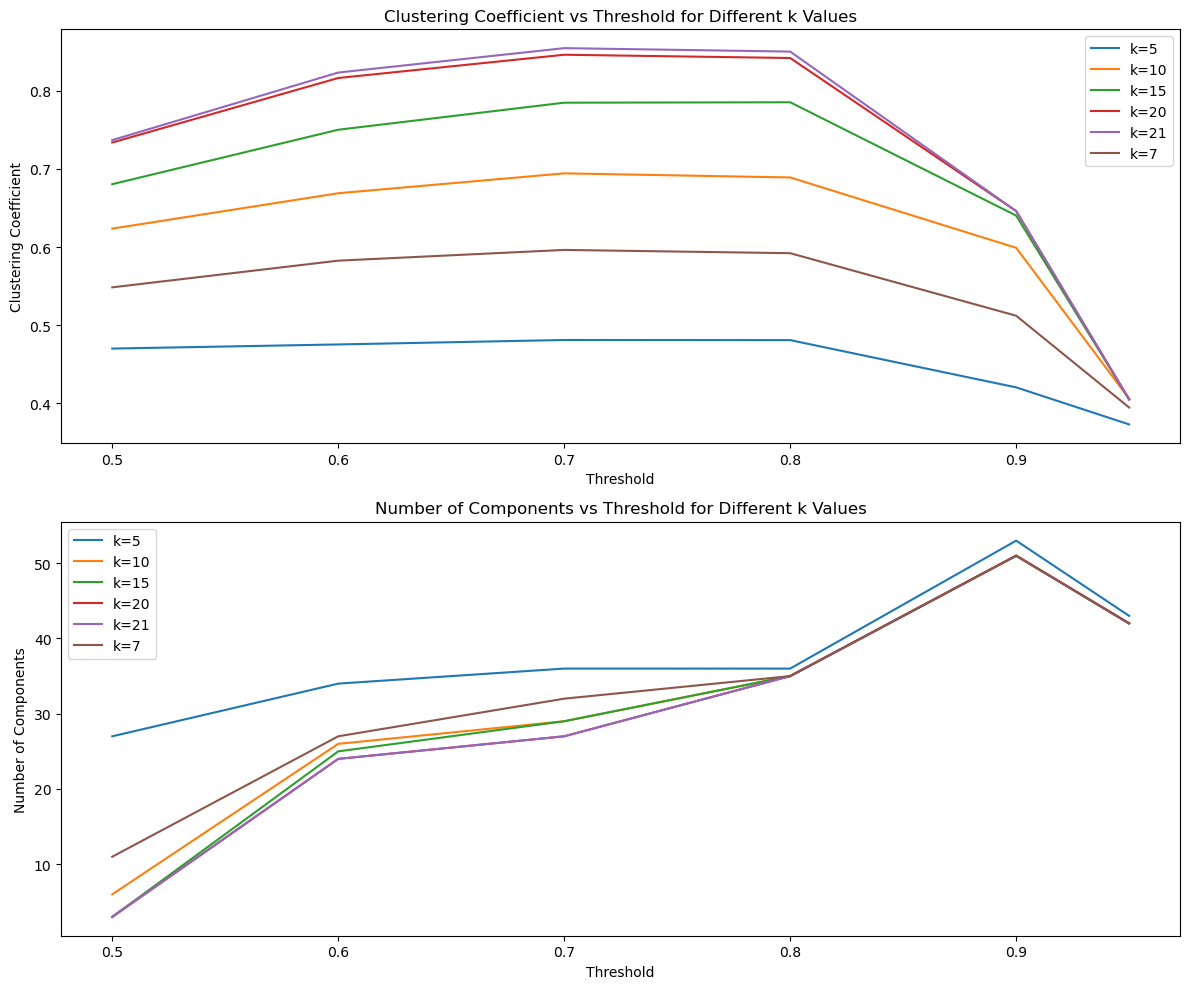

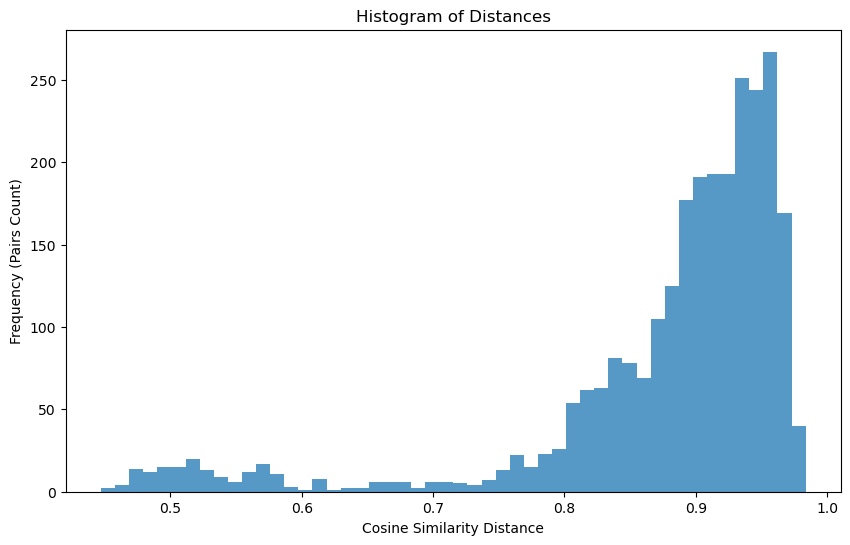

Percentiles of Distances: [0.85837287 0.90948144 0.94307196 0.95989615 0.96671832 0.97399127]


In [22]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/10_OC_romi_embeddings.csv')

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.536789              51
1    5       0.60                0.549994              57
2    5       0.70                0.551148              58
3    5       0.80                0.532868              61
4    5       0.90                0.532867              65
5    5       0.95                0.405239              82
6   10       0.50                0.666771              11
7   10       0.60                0.718562              38
8   10       0.70                0.736646              45
9   10       0.80                0.719150              51
10  10       0.90                0.677735              58
11  10       0.95                0.439980              77
12  15       0.50                0.702374               5
13  15       0.60                0.788385              33
14  15       0.70                0.824449              44
15  15       0.80                0.801204              51
16  15       0

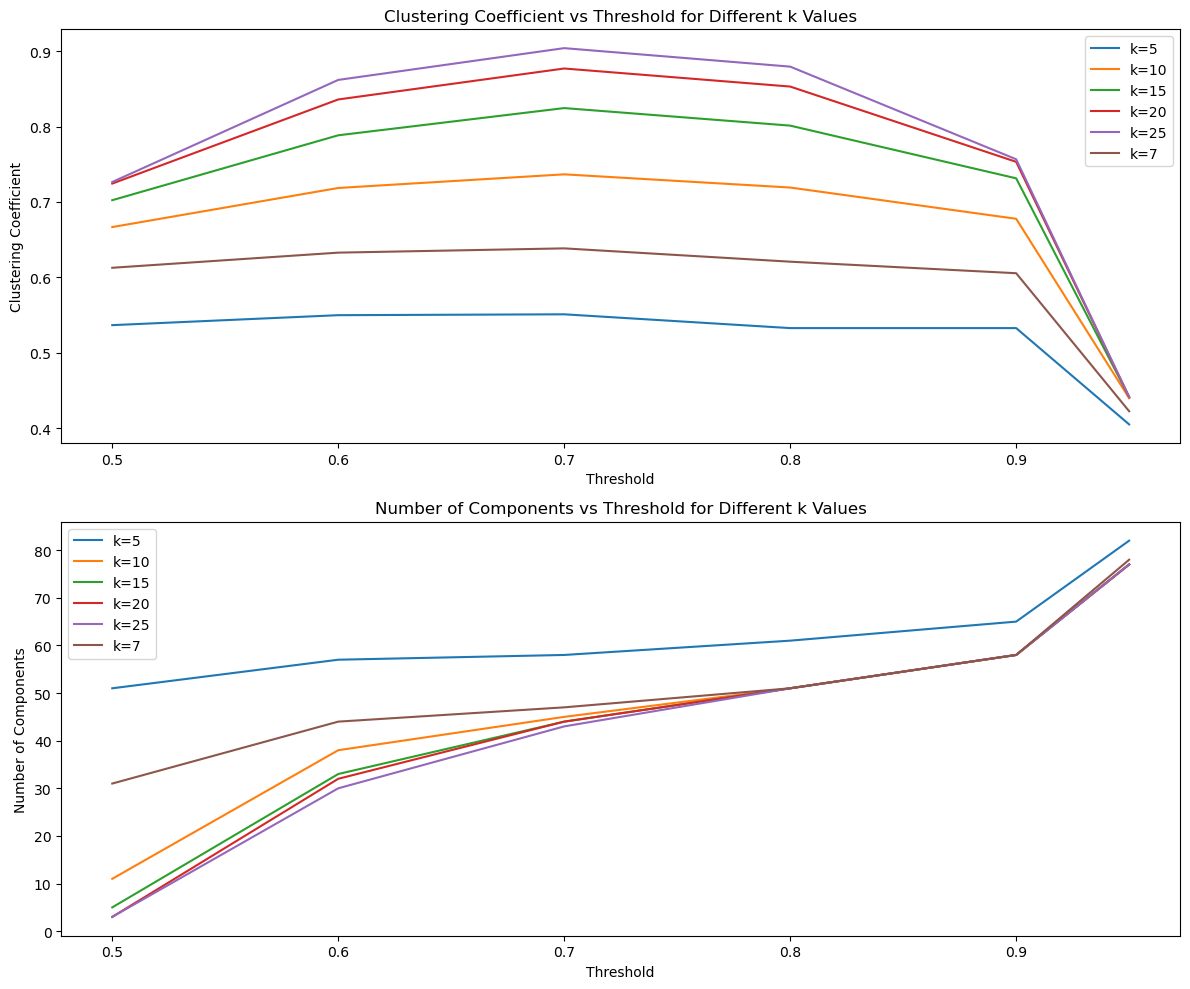

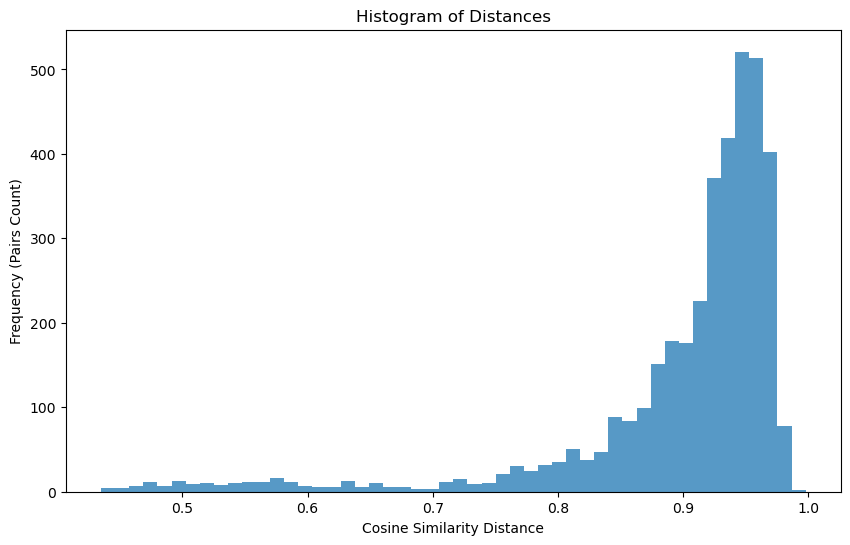

Percentiles of Distances: [0.88617226 0.93108559 0.95402402 0.9660772  0.97052717 0.97874182]


In [23]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/10_H_romi_embeddings.csv')

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.437206              39
1    5       0.60                0.439638              43
2    5       0.70                0.441513              43
3    5       0.80                0.432917              44
4    5       0.90                0.393162              70
5    5       0.95                0.361602              62
6   10       0.50                0.585822              18
7   10       0.60                0.600506              28
8   10       0.70                0.610145              34
9   10       0.80                0.604331              38
10  10       0.90                0.532068              66
11  10       0.95                0.393924              54
12  15       0.50                0.635172               3
13  15       0.60                0.677396              25
14  15       0.70                0.698277              33
15  15       0.80                0.688252              37
16  15       0

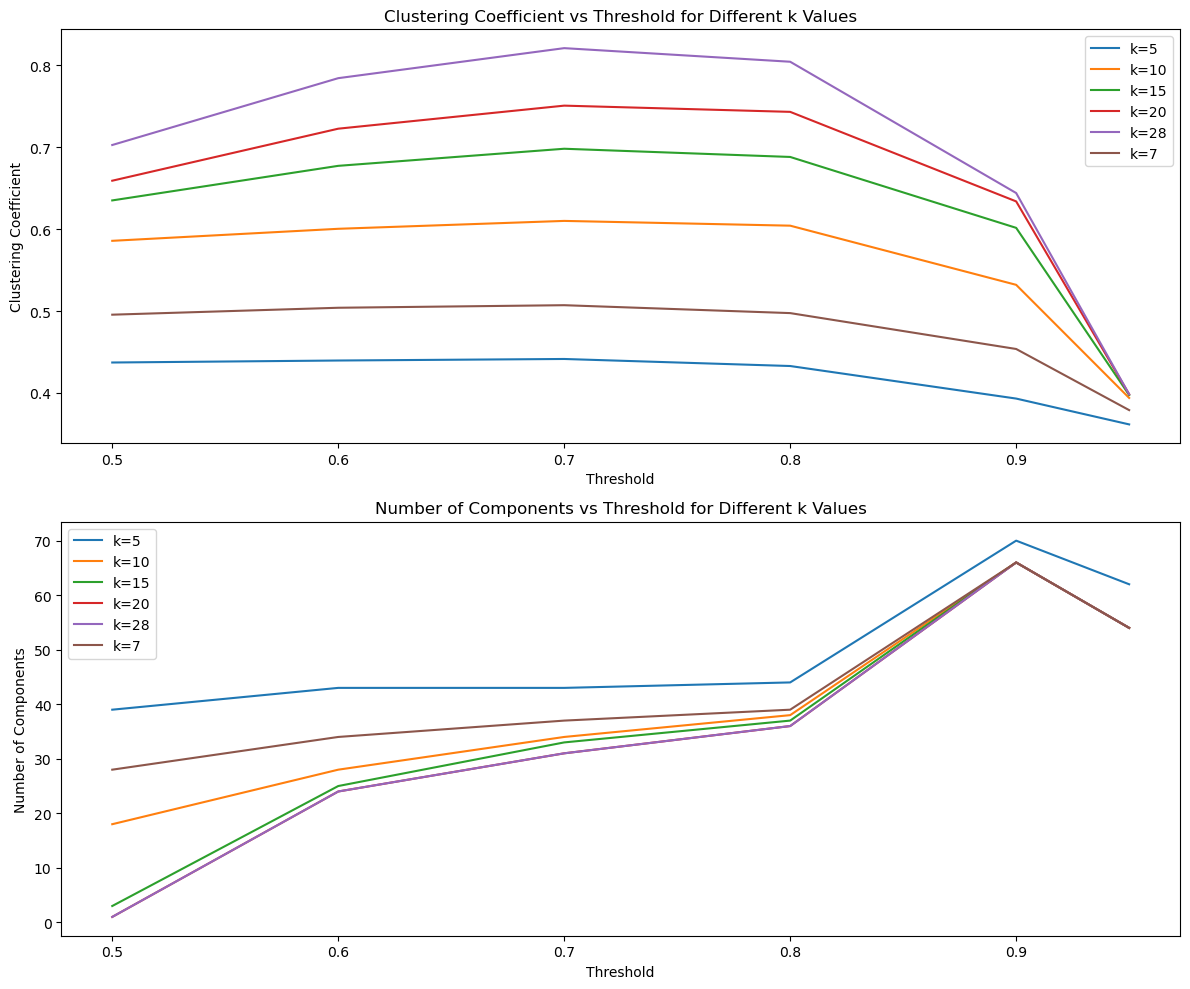

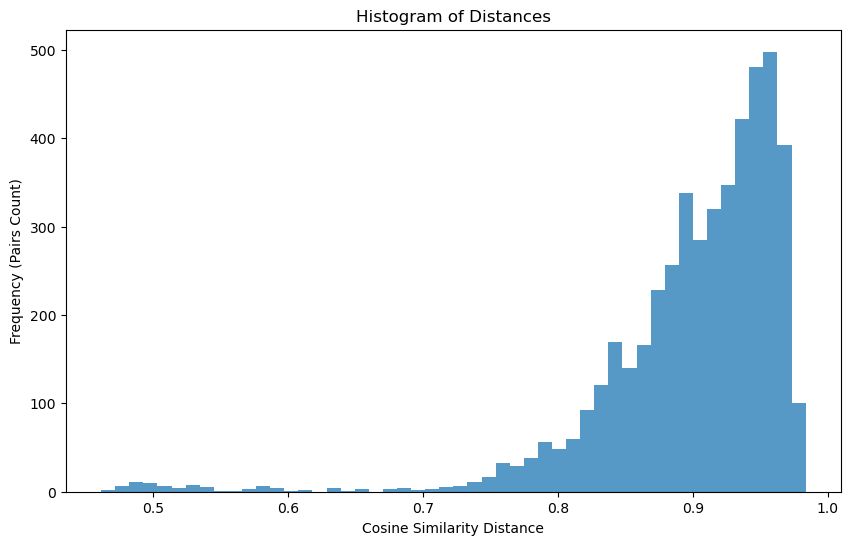

Percentiles of Distances: [0.87368287 0.91601098 0.94857077 0.9633533  0.96851873 0.97574955]


In [24]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/8_OC_romi_embeddings.csv')

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.476993              70
1    5       0.60                0.478165              74
2    5       0.70                0.478491              77
3    5       0.80                0.482042              78
4    5       0.90                0.459674              93
5    5       0.95                0.423618             121
6   10       0.50                0.593276              38
7   10       0.60                0.604313              49
8   10       0.70                0.610758              55
9   10       0.80                0.613673              60
10  10       0.90                0.583116              77
11  10       0.95                0.483583             107
12  15       0.50                0.661397              13
13  15       0.60                0.696907              43
14  15       0.70                0.710917              54
15  15       0.80                0.704733              60
16  15       0

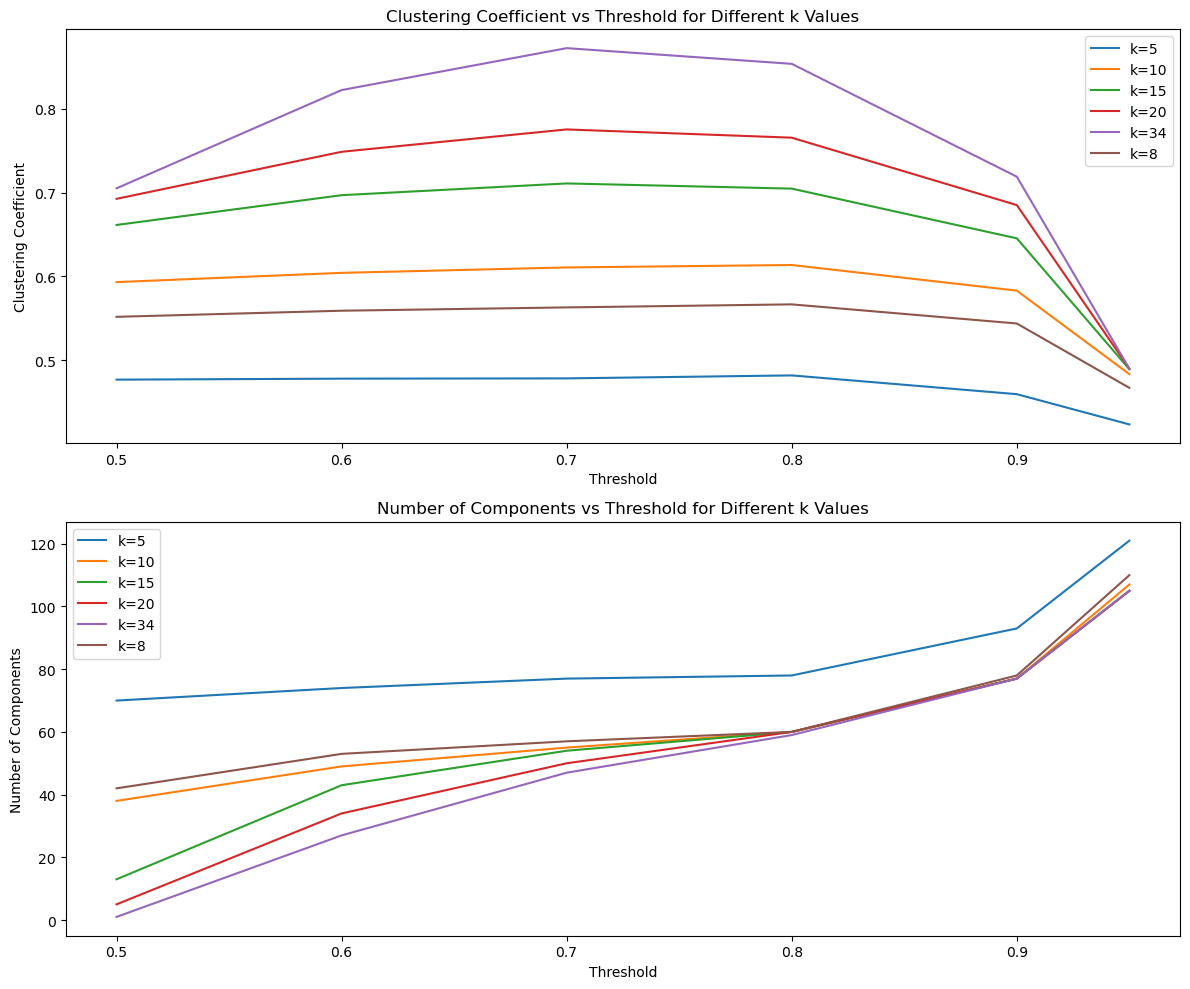

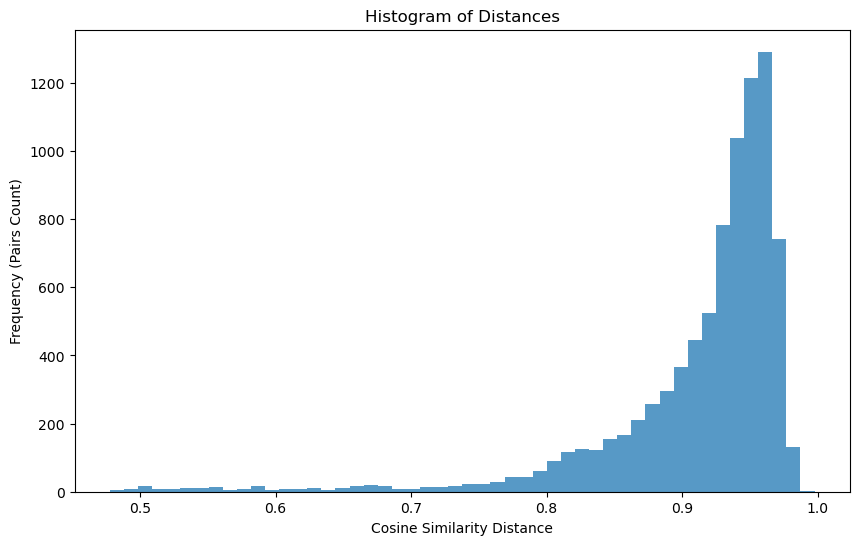

Percentiles of Distances: [0.89663883 0.93679866 0.95652735 0.96673745 0.97128987 0.97897766]


In [25]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/8_H_romi_embeddings.csv')

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.303231              95
1    5       0.60                0.303525              98
2    5       0.70                0.304378             100
3    5       0.80                0.303644             106
4    5       0.90                0.290500             263
5    5       0.95                0.325116             237
6   10       0.50                0.396982              31
7   10       0.60                0.397733              36
8   10       0.70                0.398907              39
9   10       0.80                0.400674              45
10  10       0.90                0.377577             205
11  10       0.95                0.408920             183
12  15       0.50                0.423527              27
13  15       0.60                0.424147              32
14  15       0.70                0.425630              36
15  15       0.80                0.429950              43
16  15       0

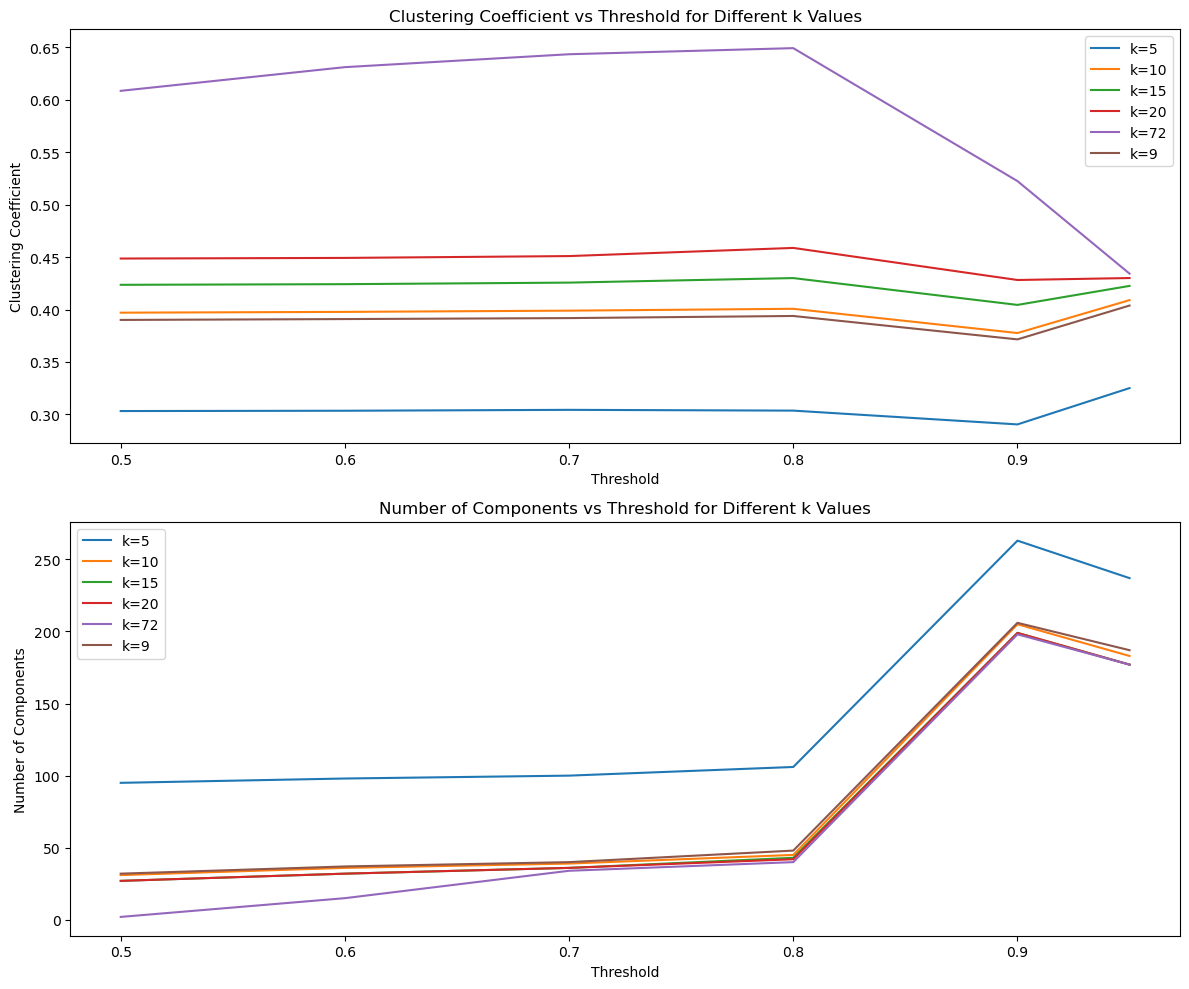

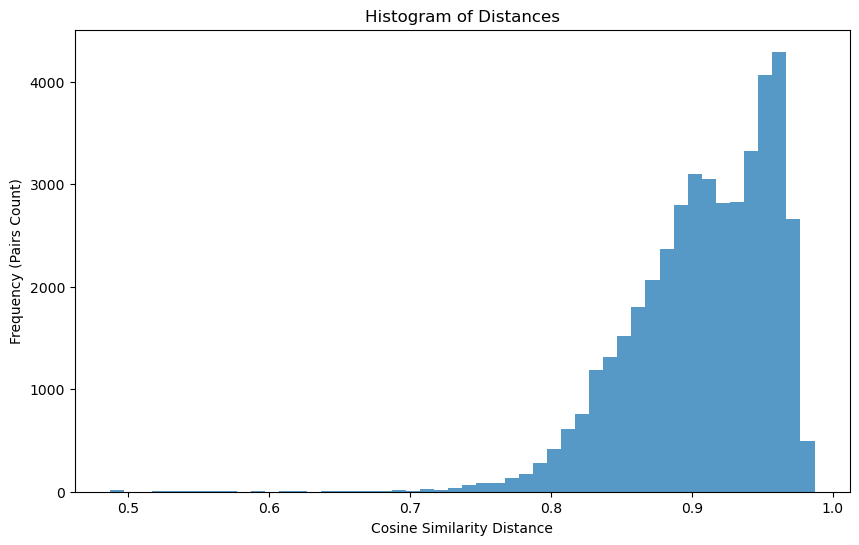

Percentiles of Distances: [0.87688088 0.91445476 0.94959779 0.96446997 0.96994901 0.97777116]


In [26]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/4_OC_romi_embeddings.csv')

     k  threshold  clustering_coefficient  num_components
0    5       0.50                0.329560             142
1    5       0.60                0.329560             142
2    5       0.70                0.329783             145
3    5       0.80                0.331612             146
4    5       0.90                0.327474             306
5    5       0.95                0.324324             399
6   10       0.50                0.420606              54
7   10       0.60                0.420573              54
8   10       0.70                0.420515              56
9   10       0.80                0.424373              62
10  10       0.90                0.412017             206
11  10       0.95                0.407780             300
12  15       0.50                0.445772              46
13  15       0.60                0.445901              46
14  15       0.70                0.446726              49
15  15       0.80                0.451039              58
16  15       0

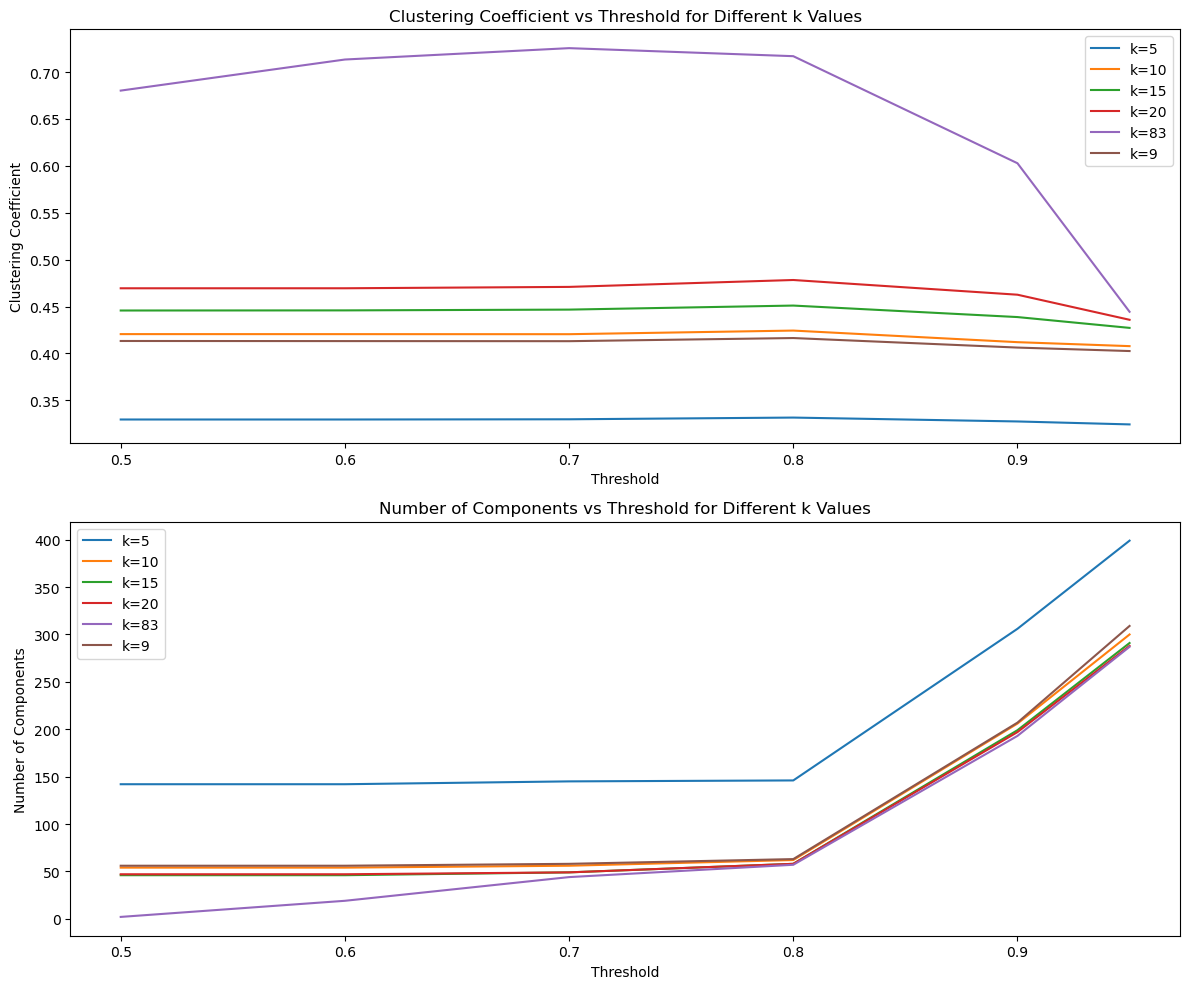

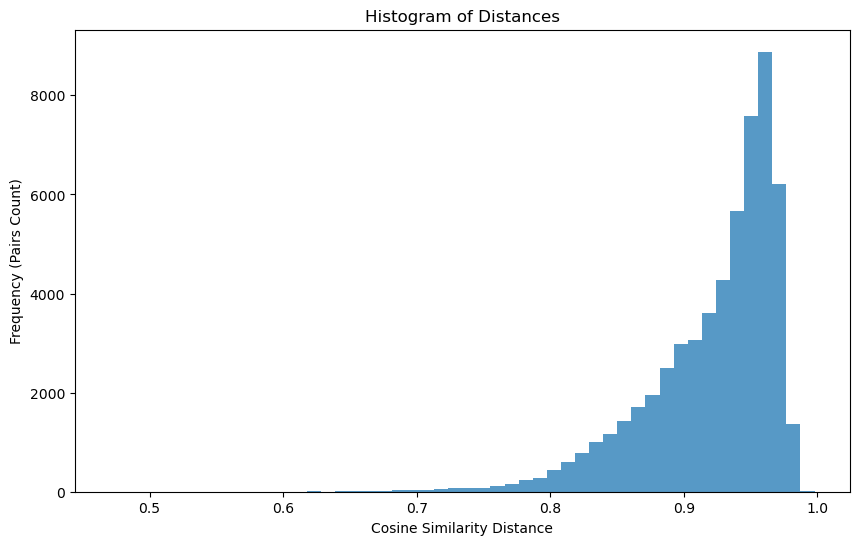

Percentiles of Distances: [0.89715314 0.93769512 0.95854896 0.9685753  0.97310622 0.97996724]


In [27]:
evaluating_thresholds('/mnt/c/Users/orrbb/Documents/BioInformatics/Msc/Master/GNN_Project/outputs/embeddings/4_H_romi_embeddings.csv')

# Running Csv files

In [ ]:
import os

input_folder = "./embeddings/romi_embeddings/"
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_folder, file_name)
        evaluating_thresholds(file_path)

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.222719             154
1     5       0.60                0.222719             154
2     5       0.70                0.222623             168
3     5       0.80                0.229333             421
4     5       0.90                0.258288             690
5     5       0.95                0.219658             563
6    10       0.50                0.279231              23
7    10       0.60                0.279338              24
8    10       0.70                0.281224              44
9    10       0.80                0.293279             256
10   10       0.90                0.331520             570
11   10       0.95                0.253287             544
12   15       0.50                0.301616              14
13   15       0.60                0.301813              15
14   15       0.70                0.304351              35
15   15       0.80                0.320491             2

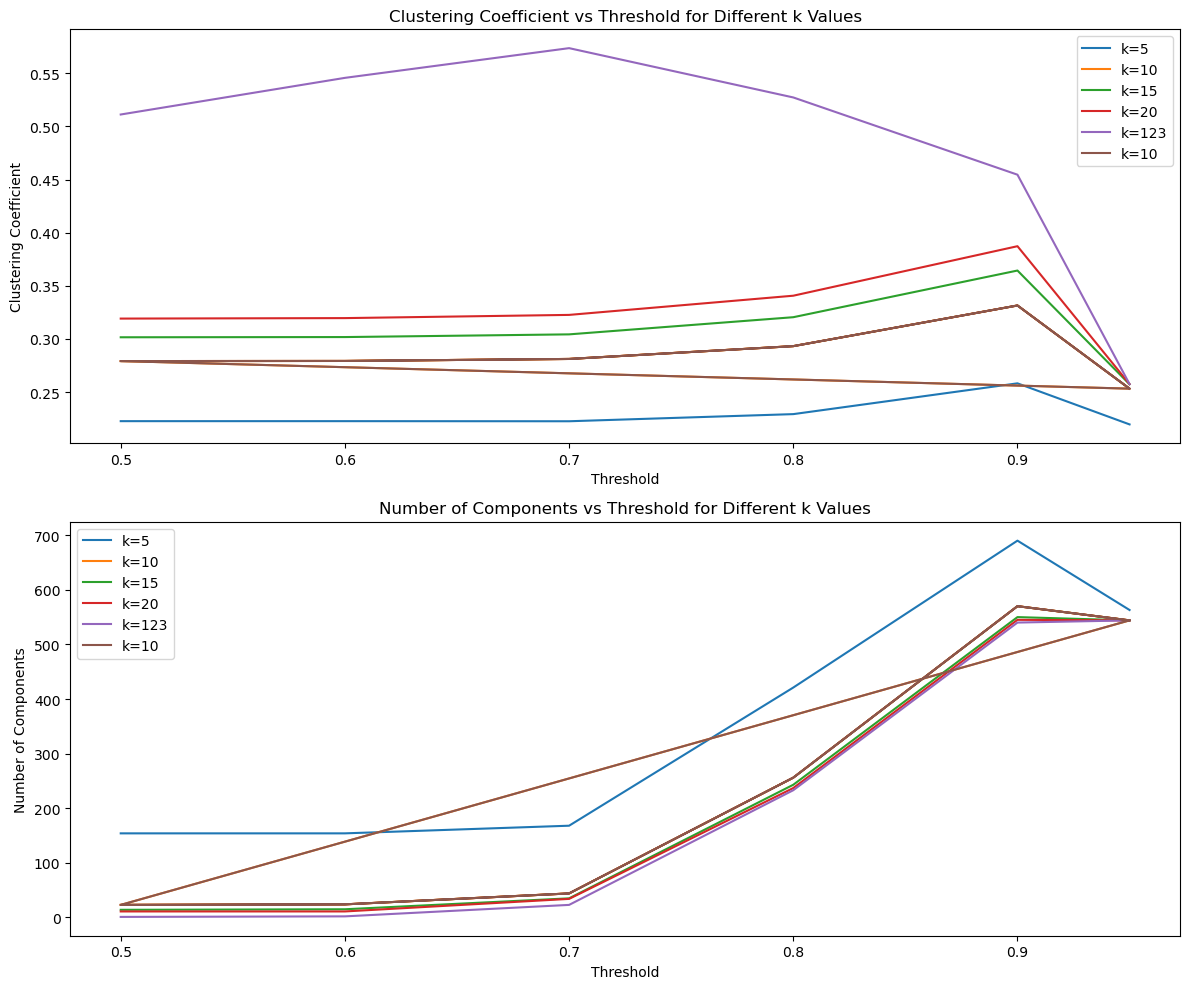

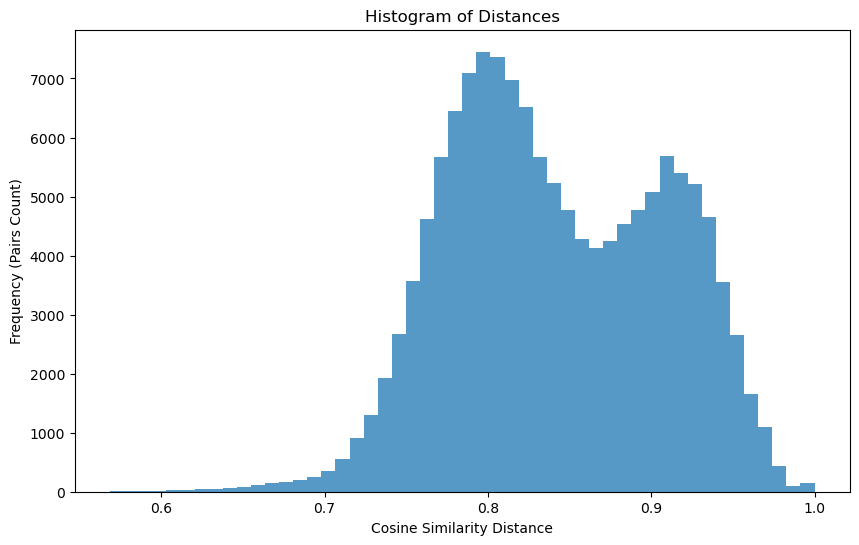

Percentiles of Distances: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]


In [3]:
evaluating_thresholds("./embeddings/romi_embeddings/32_H.csv")

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.244334             152
1     5       0.60                0.244386             152
2     5       0.70                0.244195             155
3     5       0.80                0.248093             380
4     5       0.90                0.266459             772
5     5       0.95                0.223444            1055
6    10       0.50                0.307633              19
7    10       0.60                0.307700              19
8    10       0.70                0.308195              25
9    10       0.80                0.316959             188
10   10       0.90                0.340169             595
11   10       0.95                0.266322             964
12   15       0.50                0.328043              11
13   15       0.60                0.328107              11
14   15       0.70                0.329557              17
15   15       0.80                0.340784             1

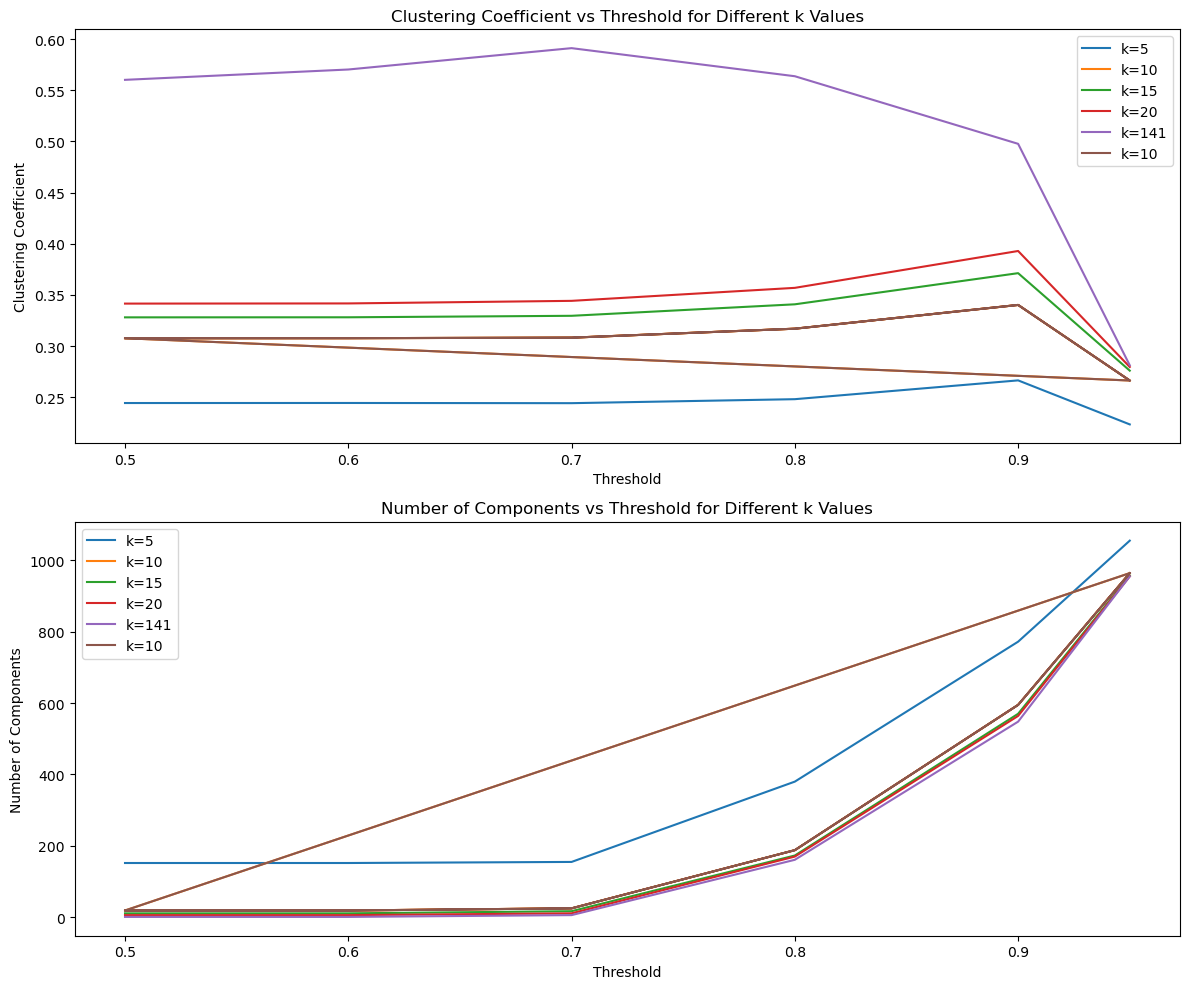

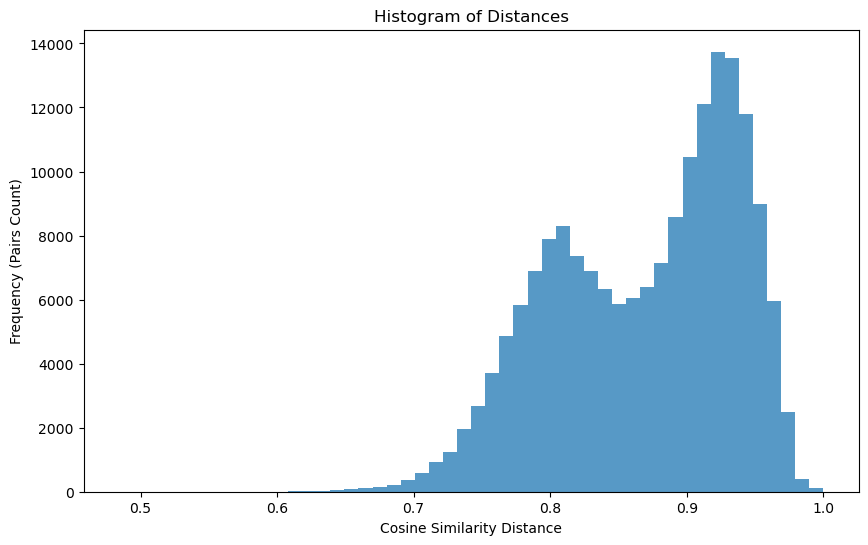

Percentiles of Distances: [0.81319791 0.88397086 0.92643112 0.9483601  0.95867813 0.97256899]


In [5]:
evaluating_thresholds("./embeddings/romi_embeddings/40_H.csv")

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.230792             194
1     5       0.60                0.230823             194
2     5       0.70                0.231086             207
3     5       0.80                0.239736             429
4     5       0.90                0.262869             704
5     5       0.95                0.222294             902
6    10       0.50                0.295347              23
7    10       0.60                0.295465              23
8    10       0.70                0.296190              36
9    10       0.80                0.306072             235
10   10       0.90                0.341813             553
11   10       0.95                0.264030             824
12   15       0.50                0.316327              11
13   15       0.60                0.316518              11
14   15       0.70                0.318506              22
15   15       0.80                0.331993             2

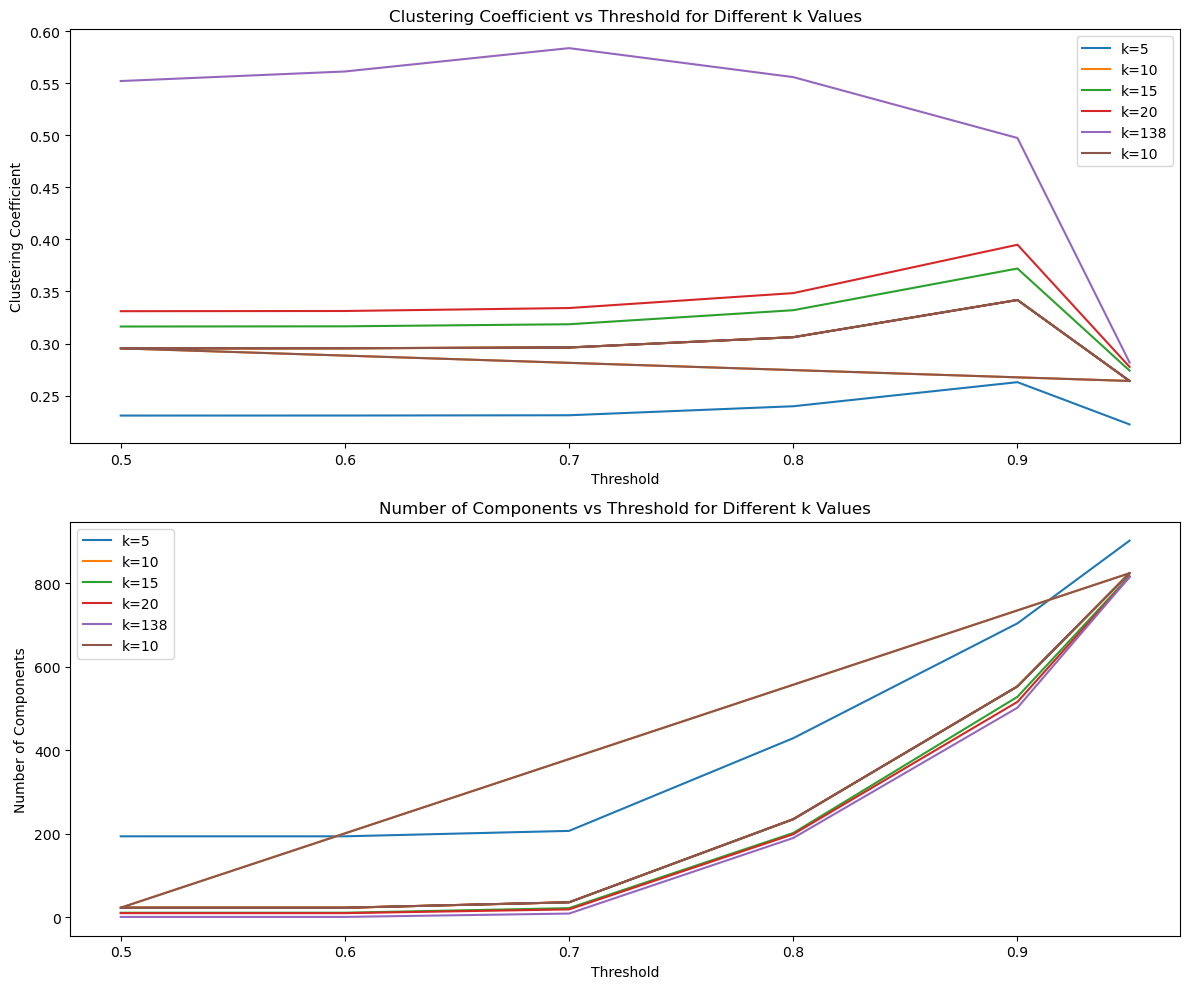

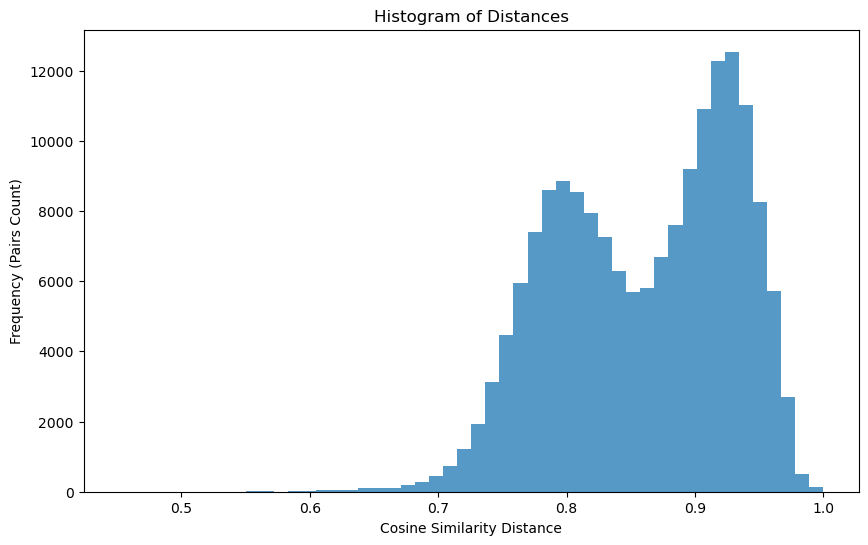

Percentiles of Distances: [0.80187124 0.87037766 0.92128652 0.9451707  0.95675641 0.97197316]


In [7]:
evaluating_thresholds("./embeddings/romi_embeddings/20_H.csv")

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.171492             131
1     5       0.60                0.171591             136
2     5       0.70                0.171853             149
3     5       0.80                0.176656             345
4     5       0.90                0.188271            1129
5     5       0.95                0.189572             320
6    10       0.50                0.221313               7
7    10       0.60                0.221736              16
8    10       0.70                0.222609              39
9    10       0.80                0.233123             173
10   10       0.90                0.237486            1057
11   10       0.95                0.216172             311
12   15       0.50                0.241239               4
13   15       0.60                0.241983              11
14   15       0.70                0.243317              35
15   15       0.80                0.259344             1

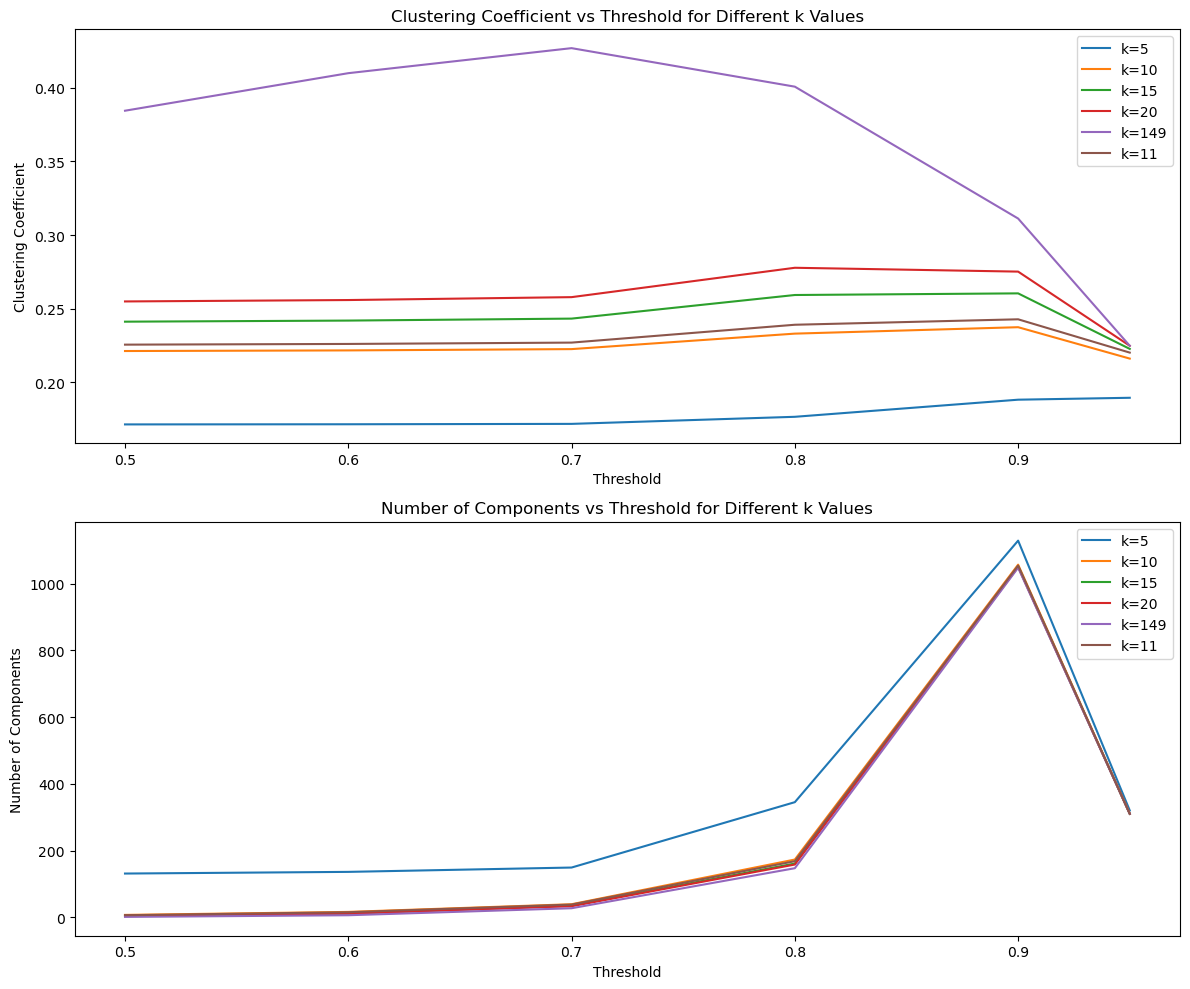

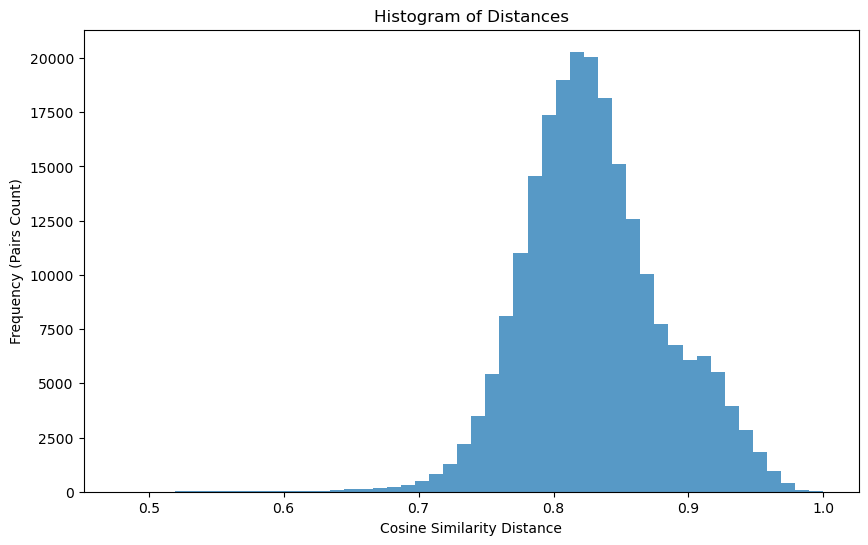

Percentiles of Distances: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]


In [4]:
evaluating_thresholds("./embeddings/romi_embeddings/2_OC.csv")

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.171492             131
1     5       0.60                0.171591             136
2     5       0.70                0.171853             149
3     5       0.80                0.176656             345
4     5       0.90                0.188271            1129
5     5       0.95                0.189572             320
6    10       0.50                0.221313               7
7    10       0.60                0.221736              16
8    10       0.70                0.222609              39
9    10       0.80                0.233123             173
10   10       0.90                0.237486            1057
11   10       0.95                0.216172             311
12   15       0.50                0.241239               4
13   15       0.60                0.241983              11
14   15       0.70                0.243317              35
15   15       0.80                0.259344             1

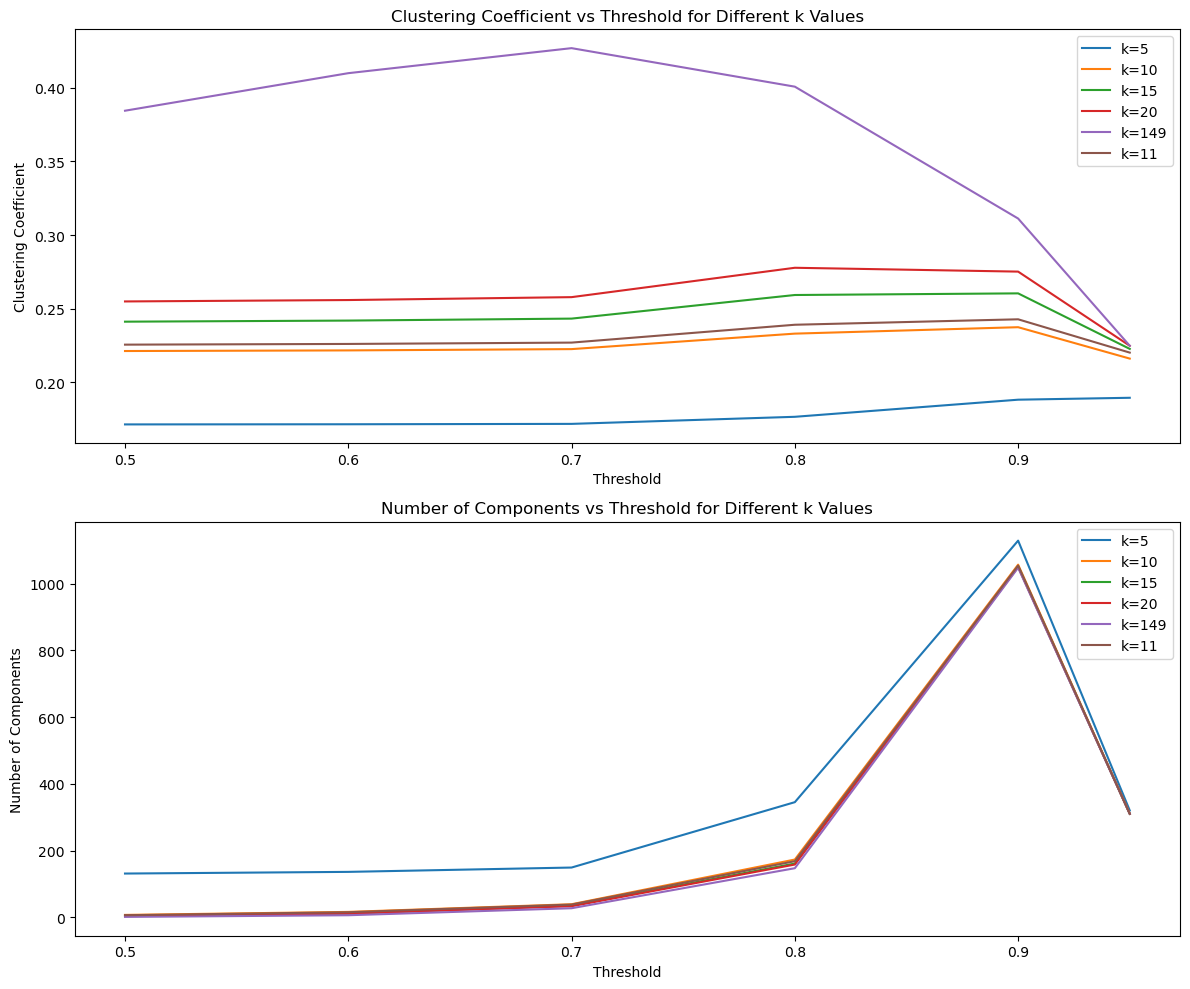

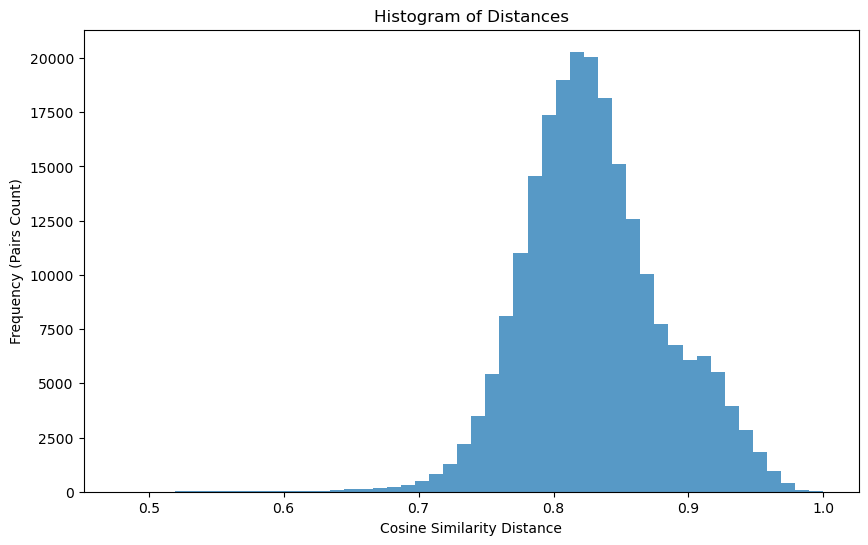

Percentiles of Distances: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]


In [6]:
evaluating_thresholds("./embeddings/romi_embeddings/14_OC.csv")

      k  threshold  clustering_coefficient  num_components
0     5       0.50                0.171492             131
1     5       0.60                0.171591             136
2     5       0.70                0.171853             149
3     5       0.80                0.176656             345
4     5       0.90                0.188271            1129
5     5       0.95                0.189572             320
6    10       0.50                0.221313               7
7    10       0.60                0.221736              16
8    10       0.70                0.222609              39
9    10       0.80                0.233123             173
10   10       0.90                0.237486            1057
11   10       0.95                0.216172             311
12   15       0.50                0.241239               4
13   15       0.60                0.241983              11
14   15       0.70                0.243317              35
15   15       0.80                0.259344             1

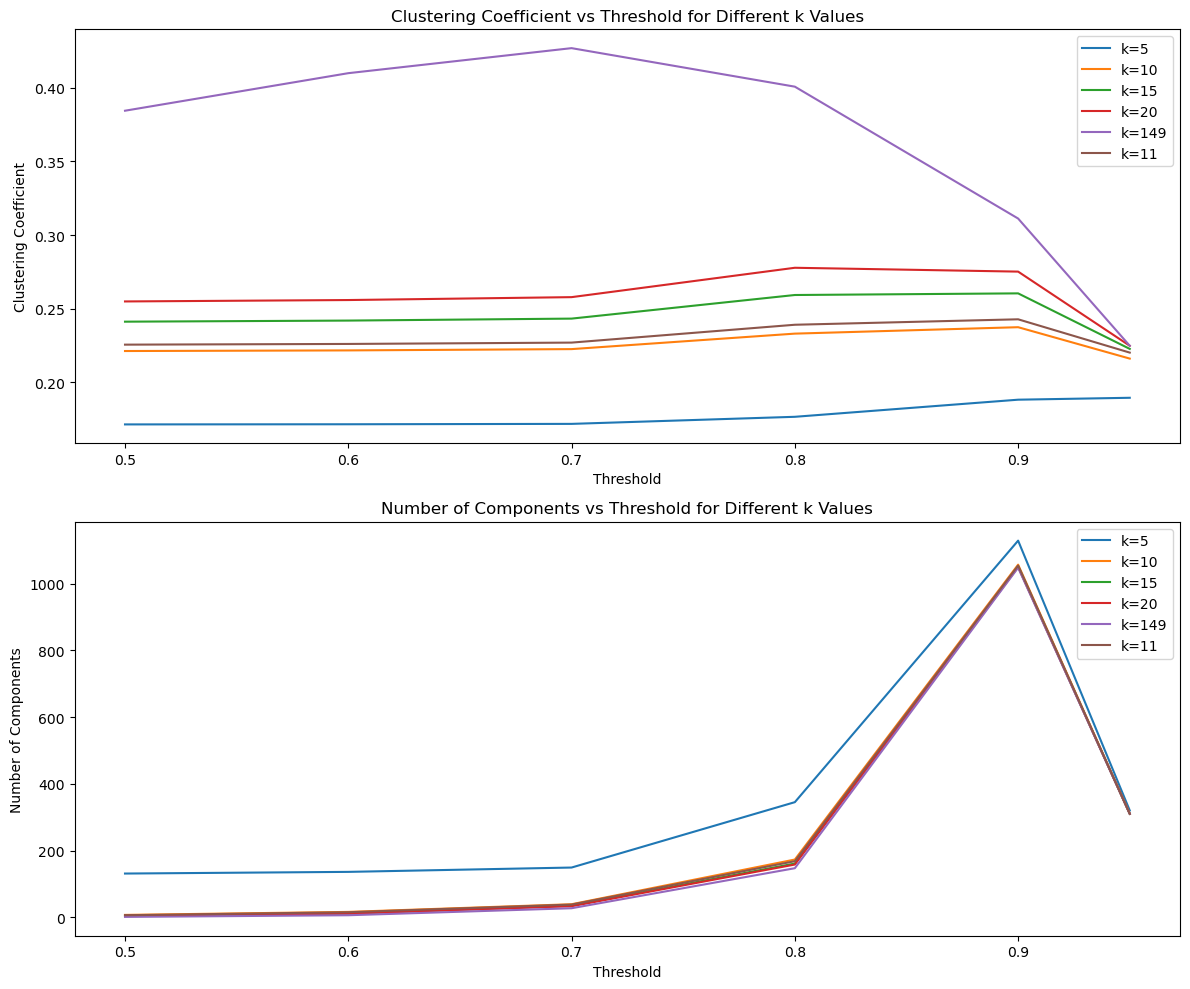

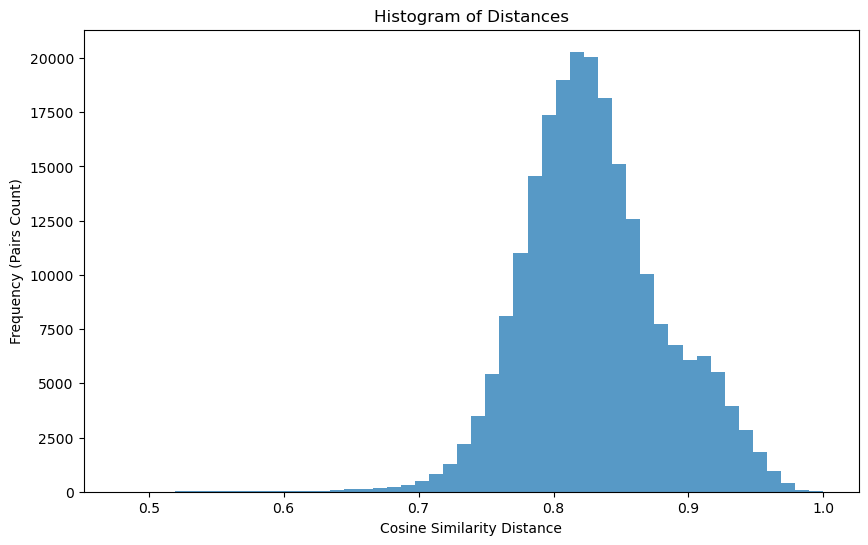

Percentiles of Distances: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]


In [12]:
evaluating_thresholds("./embeddings/romi_embeddings/26_OC.csv")